<a href="https://colab.research.google.com/github/RochaBricio/TrabalhoInfnet/blob/main/Projeto_Capstone_An%C3%A1lise_das_Esta%C3%A7%C3%B5es_de_Metr%C3%B4_de_CDMX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##Nas linhas de código abaixo concentro todos os configs e imports.


In [2]:
! pip install folium==0.5.0
! pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 3.4 MB/s 
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76133 sha256=bc193e8a701daded5a83457a6d08607b5def893cac77da8a00e62f169d9da261
  Stored in directory: /root/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium
  Attempting uninstall: folium
    Found existing installation: folium 0.8.3
    Uninstalling folium-0.8.3:
      Successfully uninstalled folium-0.8.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.5.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import requests
import json
import pandas as pd
import folium
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

##Buscando estações chaves pelo nome, latidude e longitude

In [4]:
#Estações escolhidas no mapa oficial do metrô de CDMX no site 
#https://mapa-metro.com/pt/M%C3%A9xico/Cidade%20do%20M%C3%A9xico/Cidade%20do%20M%C3%A9xico-Metro-Mapa.htm
metro_stations = {'Estações de Metrô':['Ciudad Azteca','Martín Carrera','San Lázaro','El Rosário' ,'Tacuba','Bellas Artes',
                                       'Oceanía','Tacubaya','Jamaica','La Paz','Mixcoac','Ermita', 'Universidad','Periférico Oriente','Tláhuac'],
                  'latitude':[19.534595,19.484921,19.430213,19.504541,19.459349,19.436243,19.445672,19.403439,19.409004,19.350526,19.375891,
                              19.361883,19.324427,19.3177,19.285972],
                  'longitude':[-99.0275,-99.104404,-99.114833,-99.20002,-99.189205,-99.141955,-99.087238,-99.187102,-99.122171,-98.960745,
                              -99.187531,-99.142942,-99.17397,-99.0746,-99.014194]
                  #'Ciudad Azteca':[19.534595,-99.0275],'Martín Carrera':[19.484921,-99.104404],'El Rosário':[19.504541,-99.20002],'Tacuba':[19.459349,-99.189205],'Bellas Artes':[19.436243,-99.141955],'Oceanía':[19.445672,-99.087238],'Tacubaya':[19.403439,-99.187102],'Jamaica':[19.409004,-99.122171],'La Paz':[19.350526,-98.960745],'Mixcoac':[19.375891,-99.187531],'Ermita':[19.361883,-99.142942],'Universidad':[19.324427,-99.17397],'Tláhuac':[19.285972,-99.014194]
                  }

In [5]:
#Criando o Data Frame das estações escolhidas.
df = pd.DataFrame(metro_stations)
df

,Estações de Metrô,latitude,longitude
0,Ciudad Azteca,19.534595,-99.027500
1,Martín Carrera,19.484921,-99.104404
2,San Lázaro,19.430213,-99.114833
3,El Rosário,19.504541,-99.200020
4,Tacuba,19.459349,-99.189205
5,Bellas Artes,19.436243,-99.141955
6,Oceanía,19.445672,-99.087238
7,Tacubaya,19.403439,-99.187102
8,Jamaica,19.409004,-99.122171
9,La Paz,19.350526,-98.960745


##Buscando outras estações de metrô e informações na API 

In [77]:
#função que busca dados na API
def get_venues_total(lat,long,category_id, radius):  
    ''' Function which returns number of venues considering a Foursquare cateogry and radius '''
    
    explore_url =    "https://api.foursquare.com/v3/places/search?ll={},{}&radius={}&categories={}&limit=50".format(
                      lat,
                      long,
                      radius,
                      category_id)
    headers = {
    "Accept": "application/json",
    "Authorization": "fsq3MYLeCqVIptFRe69NT3+SmCIFPDJeOoxOE/USaAsCfsA="
    }

    try:
        #response = requests.get(explore_url, headers=headers).json()['results']['totalResults']
        response = requests.get(explore_url, headers=headers).json()['results']
  
    except:
        response = 0
        
    return response

In [78]:
#busca estações de metrô ao redor das estações listadas no data frame
df_area = pd.DataFrame() #Linha passa pela primeira tabela das 12 estações e ela chama a função Get Venues Total que vai chamar na API 
for radius in [1000, 2000, 5000, 10000]:#Varrendo diferentes raios
  for row in df.iterrows(): 
    print(row[1]['Estações de Metrô'])
    latitude = row[1]['latitude']
    longitude = row[1] ['longitude']
    stations = get_venues_total(latitude, longitude,19046, radius)
  
  
    for station in stations: #guarda nome da estação, latitude e longitude
      name = station['name']
      latitude = station ['geocodes']['main']['latitude']
      longitude = station ['geocodes']['main']['longitude']
      df_area = df_area.append({'name':name,'latitude':latitude,'longitude':longitude},ignore_index=True)

Ciudad Azteca
Martín Carrera
San Lázaro
El Rosário
Tacuba
Bellas Artes
Oceanía
Tacubaya
Jamaica
La Paz
Mixcoac
Ermita
Universidad
Periférico Oriente
Tláhuac
Ciudad Azteca
Martín Carrera
San Lázaro
El Rosário
Tacuba
Bellas Artes
Oceanía
Tacubaya
Jamaica
La Paz
Mixcoac
Ermita
Universidad
Periférico Oriente
Tláhuac
Ciudad Azteca
Martín Carrera
San Lázaro
El Rosário
Tacuba
Bellas Artes
Oceanía
Tacubaya
Jamaica
La Paz
Mixcoac
Ermita
Universidad
Periférico Oriente
Tláhuac
Ciudad Azteca
Martín Carrera
San Lázaro
El Rosário
Tacuba
Bellas Artes
Oceanía
Tacubaya
Jamaica
La Paz
Mixcoac
Ermita
Universidad
Periférico Oriente
Tláhuac


In [79]:
#dropamos pelo lat long para tirar estações com endereços diferentes
df_area.drop_duplicates(subset = ['latitude','longitude'], keep = 'first', inplace = True) 

In [80]:
#dropamos estações com os nomes iguais por percerbermos que eram diferentes saídas de uma mesma estação
df_area.drop_duplicates(subset = ['name'], keep = 'first', inplace = True) 

In [81]:
#Plotando todas as estações encontradas no mapa
mapa_metro = folium.Map(location = [19.436243,-99.141955], zoom_start=10)
for station, latitude, longitude in zip(df_area['name'],df_area['latitude'],df_area['longitude']):
  folium.CircleMarker(
    [latitude,longitude],
    radius=2,
    color='red',
    popup= station,
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
  ).add_to(mapa_metro)

mapa_metro

In [82]:
 #Linha que passa pela tabela de todas as estações e ela chama a função Get Venues Total que vai chamar na API
df_venues = pd.DataFrame() 
for categoria in [13303, 16032, 10027, 19009, 10032, 17116]: #busca por categoria 
  for row in df_area.iterrows(): #passando pelas estações da minha tabela
      #print(row[1]['name'])
      latitude = row[1]['latitude']
      longitude = row[1] ['longitude']
      restaurants = get_venues_total(latitude, longitude, categoria, 1000) #busca estabelecimentos em um raio específico a cada categoria. 

      for restaurant in restaurants: #guardando a estação, a categoria e a distância de cada estabelecimento. 
        station = row[1]['name']
        distancia = restaurant['distance']
        df_venues = df_venues.append({'station':station,'categoria':categoria, 'distance': distancia},ignore_index=True)          

In [83]:
df_venues.head()

,station,categoria,distance
0,Mexipuerto,13303.0,23.0
1,Mexipuerto,13303.0,674.0
2,Mexipuerto,13303.0,723.0
3,Mexipuerto,13303.0,681.0
4,Mexipuerto,13303.0,503.0


##Ajustando os dados encontrados.

In [84]:
#Agrupamento dos resultados de busca por estação e categoria.
df_venues2 = df_venues.groupby(['station', 'categoria'])['categoria'].count().reset_index(name = 'quantidade')
df_venues2.head(10)

,station,categoria,quantidade
0,201 II W.W. Mexican Air Force Scuadron Subway ...,10027.0,1
1,201 II W.W. Mexican Air Force Scuadron Subway ...,10032.0,2
2,201 II W.W. Mexican Air Force Scuadron Subway ...,13303.0,50
3,201 II W.W. Mexican Air Force Scuadron Subway ...,16032.0,10
4,201 II W.W. Mexican Air Force Scuadron Subway ...,19009.0,4
5,Apatlaco,10027.0,1
6,Apatlaco,13303.0,50
7,Apatlaco,16032.0,9
8,Apatlaco,19009.0,8
9,Azcapotzalco,10032.0,2


In [85]:
#Redividindo o agrupamento feito anteriormente. Resetando o índice. 
df_venues3 = pd.pivot_table(df_venues2, index = 'station', columns = 'categoria', values = 'quantidade', fill_value=0)
df_venues3.reset_index(inplace=True)
df_venues3.head()

categoria,station,10027.0,10032.0,13303.0,16032.0,17116.0,19009.0
0,201 II W.W. Mexican Air Force Scuadron Subway ...,1,2,50,10,0,4
1,Apatlaco,1,0,50,9,0,8
2,Azcapotzalco,0,2,40,3,0,1
3,Balderas Metro,49,21,50,19,0,50
4,Constituyentes,23,2,50,15,0,10


In [86]:
#Renomeando as colunas. 
df_venues3.rename(columns = {'station':'Estações', 10027.0:'Museu', 13303.0:'Restaurantes', 
                             16032.0:'Parques', 10032.0:'Casas Noturnas', 19009.0:'Alojamento', 
                             17116.0:'Loja de Souvenir'},inplace=True)

,Estações,Museu,Casas Noturnas,Restaurantes,Parques,Loja de Souvenir,Alojamento
Index,,,,,,,
0,201 II W.W. Mexican Air Force Scuadron Subway ...,1,2,50,10,0,4
1,Apatlaco,1,0,50,9,0,8
2,Azcapotzalco,0,2,40,3,0,1
3,Balderas Metro,49,21,50,19,0,50
4,Constituyentes,23,2,50,15,0,10
...,...,...,...,...,...,...,...
142,Universidad Autonoma Metropolitana,0,0,50,6,0,7
143,Viaducto,2,2,50,11,1,23
144,Villa de cortes,2,4,50,15,0,13


##Clusterizando

In [87]:
#Normalizando os dados.
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_venues3[['Museu', 'Casas Noturnas', 'Restaurantes', 'Parques', 'Loja de Souvenir', 'Alojamento']])

In [98]:
#Criando novo Data Frame sem a categoria alvo.
df_clust = pd.DataFrame(scaled, columns = ['Museu', 'Casas Noturnas', 'Restaurantes', 'Parques', 'Loja de Souvenir', 'Alojamento'])
df_clust.head()

,Museu,Casas Noturnas,Restaurantes,Parques,Loja de Souvenir,Alojamento
0,0.02,0.04,1.000000,0.250,0.0,0.08
1,0.02,0.00,1.000000,0.225,0.0,0.16
2,0.00,0.04,0.795918,0.075,0.0,0.02
3,0.98,0.42,1.000000,0.475,0.0,1.00
4,0.46,0.04,1.000000,0.375,0.0,0.20


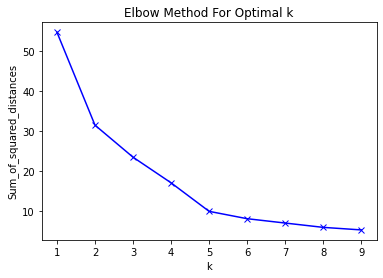

In [99]:
#método do cotovelo
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_clust)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


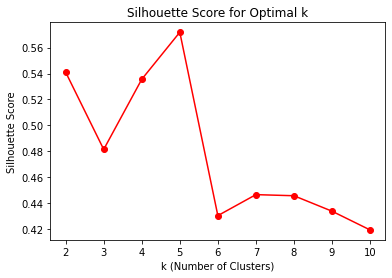

In [100]:
#metodo da silhueta
sil = []
kmax = 10

for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(df_clust)
  labels = kmeans.labels_
  sil.append(silhouette_score(df_clust, labels, metric = 'euclidean'))

plt.plot(range(2, kmax+1), sil, 'ro-')
plt.title('Silhouette Score for Optimal k')
plt.xlabel('k (Number of Clusters)')
plt.ylabel('Silhouette Score')
plt.show()


In [101]:
#dividindo os clusters de acordo com os resultados encontrados.
k = 5 # number of clusters

model = KMeans(n_clusters=k, random_state=0).fit(df_clust)
model.labels_ # Cluster labels generated for each row


array([1, 1, 1, 3, 1, 0, 1, 2, 4, 1, 3, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 3,
       3, 1, 1, 1, 3, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 4, 1, 0, 1, 4, 3, 2, 1, 1, 1, 1, 2,
       2, 1, 3, 3, 2, 2, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 4, 1, 0, 1, 4, 4,
       3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 4, 4, 1, 3, 0, 1, 1, 4, 1, 1, 4, 4,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 4, 1, 1, 4, 1, 1, 1, 1, 0, 4, 1,
       1, 2, 2, 4, 4, 4, 0, 0, 1, 1, 1, 0, 1, 2, 0], dtype=int32)

In [102]:
#Incorporando os clusters ao Data Frame Original
df_venues3['Cluster'] = model.labels_
df_venues3.head()


categoria,Estações,Museu,Casas Noturnas,Restaurantes,Parques,Loja de Souvenir,Alojamento,Cluster
0,201 II W.W. Mexican Air Force Scuadron Subway ...,1,2,50,10,0,4,1
1,Apatlaco,1,0,50,9,0,8,1
2,Azcapotzalco,0,2,40,3,0,1,1
3,Balderas Metro,49,21,50,19,0,50,3
4,Constituyentes,23,2,50,15,0,10,1


##Analisando os Clusters

In [ ]:
#Para o futuro, analisar estatísticamente cada cluster. 
#cluster0 = df_venues3.loc[df_venues3['cluster'] == 3].reset_index(drop=True)   filtrar clusters no df original
#cluster0.describe    reter as estatísticas


In [106]:
#Criando Data Frame com todos os dados
df_cdmx = df_area.merge(df_venues3, left_on='name', right_on='Estações')
df_cdmx.head()

,name,latitude,longitude,Estações,Museu,Casas Noturnas,Restaurantes,Parques,Loja de Souvenir,Alojamento,Cluster
0,Mexipuerto,19.534117,-99.026911,Mexipuerto,0,2,46,5,0,3,1
1,Metro Martín Carrera,19.485824,-99.105669,Metro Martín Carrera,1,0,50,5,0,4,1
2,Martín Carrera,19.485050,-99.104344,Martín Carrera,1,0,50,6,0,3,1
3,Metrobus Hospital General la Villa,19.481961,-99.105107,Metrobus Hospital General la Villa,1,0,50,5,0,5,1
4,Metro Garibaldi,19.432698,-99.110272,Metro Garibaldi,2,0,50,12,0,12,1


In [107]:
#Preparando dicionário para as cores
colorcluster = {0:'royalblue', 1:'limegreen', 2:'indianred', 3:'darkviolet', 4:'darkorange' }

In [109]:
#Criando mapa com os clusters
mapa_metro_cluster = folium.Map(location = [19.436243,-99.141955], zoom_start=10)
for station, latitude, longitude, cluster in zip(df_cdmx['name'],df_cdmx['latitude'],df_cdmx['longitude'],df_cdmx['Cluster']):
  folium.CircleMarker(
    [latitude,longitude],
    radius=2,
    color= colorcluster[cluster],
    popup= str(cluster),
    fill = True,
    fill_color = colorcluster[cluster],
    fill_opacity = 0.6
  ).add_to(mapa_metro_cluster)

mapa_metro_cluster

In [111]:
#Adicionando clusters ao Data Frame normalizado para melhor visualização
df_clust['cluster'] = df_venues3['Cluster']

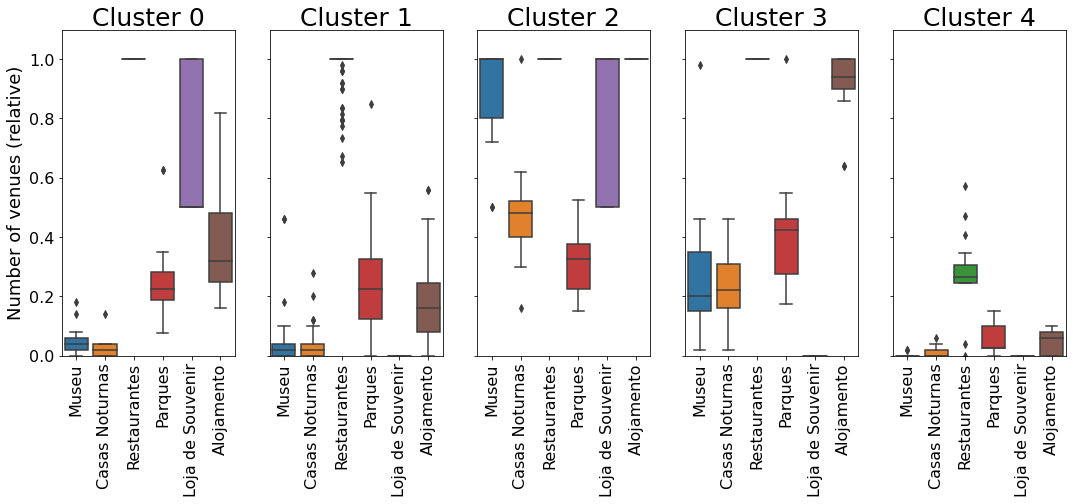

In [113]:
#Criando boxplots para analisar as diferenças entre clusters. 
kclusters = 5
fig, axes = plt.subplots(1, kclusters, figsize=(18, 6), sharey=True )

axes[0].set_ylabel('Number of venues (relative)', fontsize=18)

for k in range(kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].tick_params(labelsize=16)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = df_clust[df_clust['cluster'] == k].drop(columns='cluster'), ax=axes[k])

plt.show()
